# <span style="font-size: 30px;">EJERCICIO DE CLASIFICACIÓN BAYESIANA </span>

A partir del dataset de pesos y alturas, construir manualmente (sin usar sklearn) un Clasificador Bayesiano LDA. Para calcular los parámetros, utilizar las fórmulas compartidas en el notebook correspondiente.

## Librerias

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## <span style="font-size: 24px;">Preparación de los datos</span>

In [147]:
data_train=pd.read_csv('alturas-pesos-mils-train.csv')
data_test=pd.read_csv('alturas-pesos-mils-test.csv')

In [148]:
#Paso la infromación del .csv a vectores para que sea más fácil manipular la información
genero_train= data_train['Genero']
wh_train=data_train.iloc[:, 2:4].values

genero_test= data_test['Genero']
wh_test=data_test.iloc[:, 2:4].values

In [149]:
wh_train

array([[ 61.235, 162.402],
       [ 97.432, 181.908],
       [ 73.324, 172.459],
       ...,
       [ 75.461, 170.91 ],
       [ 65.461, 166.137],
       [ 80.323, 171.575]], shape=(8000, 2))

In [150]:
wh_test

array([[ 90.202, 177.68 ],
       [ 60.89 , 164.175],
       [ 67.629, 171.506],
       ...,
       [ 51.971, 154.277],
       [ 82.536, 172.26 ],
       [ 62.409, 166.244]], shape=(2000, 2))

In [201]:
data_hombre_test = data_test.loc[data_test['Genero']=='Hombre'][['Peso','Altura']].values
data_mujeres_test = data_test.loc[data_test['Genero']=='Mujer'][['Peso','Altura']].values
data_hombres_train = data_train.loc[data_train['Genero']=='Hombre'][['Peso','Altura']].values
data_mujeres_train = data_train.loc[data_train['Genero']=='Mujer'][['Peso','Altura']].values


## <span style="font-size: 24px;">A. Clasificador manual</span>

In [151]:
#Calculo las priors: la probabilidad de que una persona sea hombre o mujer
total=len(genero_train)
cant_hombres=len(genero_train[genero_train=='Hombre'])
cant_mujeres=len(genero_train[genero_train=='Mujer'])
suma=cant_mujeres + cant_hombres #esto es útil para asegurarse de que no hay otro tipo de dato
print("TOTAL:", total, "\nMUJERES",  cant_mujeres, "\nHOMBRES:", cant_hombres, "\nSUMA:", suma)
prior_hombre=cant_hombres/total
prior_mujer=cant_mujeres/total
print("PRIOR HOMBRES:", prior_hombre, "\nPRIOR MUJERES:", prior_mujer)

TOTAL: 8000 
MUJERES 3998 
HOMBRES: 4002 
SUMA: 8000
PRIOR HOMBRES: 0.50025 
PRIOR MUJERES: 0.49975


\begin{equation}
  P(C_{i} | w, h) = \frac{P( w, h | C_{i})\times P(C_{i})}{P(w,h)}
\end{equation}

Veo que la altura va de 140 a 200cm, y los pesos de 20 a 140kg.

In [152]:
#Propiedades para los bines
minw=20
maxw=130
minh=135
maxh=225
cantidad_bines=100
ancho_bines_peso=(maxw-minw)/cantidad_bines
ancho_bines_altura=(maxh-minh)/cantidad_bines

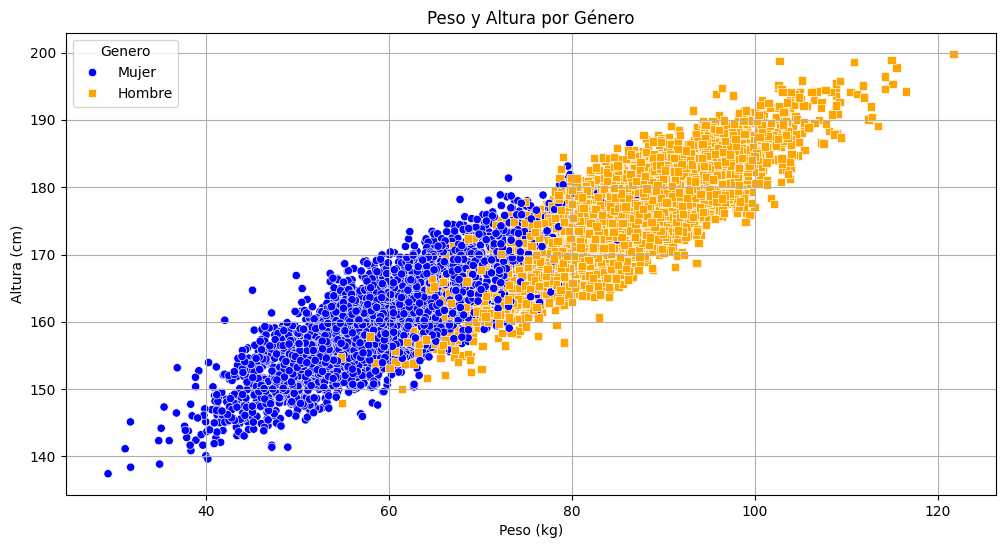

In [153]:
import seaborn as sns

# Crear un DataFrame combinado para facilitar el plot
data_combined = pd.concat([data_train, data_test])

# Crear el plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data_combined, x='Peso', y='Altura', hue='Genero', style='Genero', markers=['o', 's'], palette=['blue', 'orange'])
plt.title('Peso y Altura por Género')
plt.xlabel('Peso (kg)')
plt.ylabel('Altura (cm)')
plt.grid(True)
plt.show()

## OPCIÓN 1: diseñamos un primer clasificador que si llega a un dato que no se puede clasificar, no lo toma en consideración

In [154]:
#OPCIÓN 1 - Si llega a un dato que no se puede clasificar, no lo toma en consideración
def probabilidad_wh_A(wh_vector, genero):
  cont_wh=0
  cont_dado_genero=0
  if(genero=='Hombre'):
    cant_genero=cant_hombres
  else:
    cant_genero=cant_mujeres

  peso=wh_vector[0]
  altura=wh_vector[1]

  #identifico en qué bin está
  binW=int((peso-minw)/ancho_bines_peso)
  binH=int((altura-minh)/ancho_bines_altura)

  infW=minw+binW*ancho_bines_peso #límite inferior de peso del bin
  supW=minw+(binW+1)*ancho_bines_peso #límite superior de peso del bin
  infH=minh+binH*ancho_bines_altura #límite inferior de altura del bin
  supH=minh+(binH+1)*ancho_bines_altura #límite superior de altura del bin

  #cuento cuántas muestras hay en ese bin
  for i in range(total):
    if (infW<= wh_train[i, 0] <supW) and (infH<= wh_train[i,1] <supH):
      cont_wh+=1
      if (genero_train[i]==genero):
        cont_dado_genero+=1

  if cont_wh==0:
    clasificado=False
    proba=0
    likelihood=0
  else:
      clasificado=True
      proba=cont_wh/total
      likelihood=cont_dado_genero/cant_genero
  
  return proba, likelihood, clasificado

In [155]:
def clasificador_manual_A(wh_vector, genero_vector):
    cant_noClasificados=0
    prediccion=[] #en este vector guardo los resultados de la predicción

    #Recorre todos los elementos del array y los clasifica 
    for i in range(len(genero_vector)):
        #print("Evalúo el elemento ",i, "---PESO=", peso_train[i], "---ALTURA=", altura_train[i])
        proba_wh, likelihood_hombre,clasificado= probabilidad_wh_A(wh_vector[i], 'Hombre')

        if clasificado==True:
            #Calculo, por medio del teorema de Bayes, la probabilidad de que sea hombre
            hombre_dado_wh= (likelihood_hombre * prior_hombre)/proba_wh
            if(hombre_dado_wh>0.5):
                prediccion.append(1) #de esta forma, HOMBRE=1 MUJER=0
            else:
                prediccion.append(0)
        if clasificado==False:
            cant_noClasificados+=1
            print("La muestra ", i, "no se pudo clasificar")
    
    print("\n\nHUBO ", cant_noClasificados, " ELEMENTOS QUE NO PUDIERON SER CLASIFICADOS")
    #una vez que termina, convierto la lista con las predicciones en array
    prediccion=np.array(prediccion)

    return prediccion

OPCIÓN 2: En este segundo clasificador, si hay un dato que no puede ser clasificado, se compara esa muestra con los bins de alrededor del bin que le corresponde. Se ampliará el área de comparación hasta que la muestra pueda ser clasificada.

In [156]:
def probabilidad_wh_B(wh_vector, genero, indice):
  cont_wh=0
  k=-1
  cont_dado_genero=0
  if(genero=='Hombre'):
    cant_genero=cant_hombres
  else:
    cant_genero=cant_mujeres

  peso=wh_vector[0]
  altura=wh_vector[1]
  #identifico en qué bin está
  binW=int((peso-minw)/ancho_bines_peso)
  binH=int((altura-minh)/ancho_bines_altura)

  while(cont_wh==0): #Si encontró al menos un elemento en el mismo bin, sigue. Sino, se aplía el bin y se vuelve a hacer la búsqueda.
    k+=1
    infW=minw+(binW-k)*ancho_bines_peso #límite inferior de peso del bin
    supW=minw+(binW+1+k)*ancho_bines_peso #límite superior de peso del bin
    infH=minh+(binH-k)*ancho_bines_altura #límite inferior de altura del bin
    supH=minh+(binH+1+k)*ancho_bines_altura #límite superior de altura del bin

    #cuento cuántas muestras hay en ese bin
    for i in range(total):
      if (infW<= wh_train[i, 0] <supW) and (infH<= wh_train[i,1] <supH):
        cont_wh+=1
        if (genero_train[i]==genero):
          cont_dado_genero+=1
  
  if k!=0:
    print("Para la muestra ", indice, "Se amplió ", k, "veces el espacio de comparación")

  proba=cont_wh/total
  likelihood=cont_dado_genero/cant_genero

  return proba, likelihood

In [157]:
def clasificador_manual_B(wh_vector, genero_vector):
    prediccion=np.zeros(len(genero_vector)) #en este vector guardo los resultados de la predicción

    #Recorre todos los elementos del array y los clasifica 
    for i in range(len(genero_vector)):
        #print("Evalúo el elemento ",i, "---PESO=", peso_train[i], "---ALTURA=", altura_train[i])
        proba_wh, likelihood_hombre= probabilidad_wh_B(wh_vector[i], 'Hombre', i)
        hombre_dado_wh= (likelihood_hombre * prior_hombre)/proba_wh
        if(hombre_dado_wh>0.5):
            prediccion[i]=1 

    return prediccion

## <span style="font-size: 20px;"> A.1. Imágenes de entrenamiento </span>

In [158]:
#con la primera opción
prediccion_manual_train_A=clasificador_manual_A(wh_train, genero_train)



HUBO  0  ELEMENTOS QUE NO PUDIERON SER CLASIFICADOS


In [159]:
prediccion_manual_train_B=clasificador_manual_B(wh_train, genero_train)

## <span style="font-size: 20px;"> A. 2. Imágenes de testeo </span>

In [160]:
prediccion_manual_test_A=clasificador_manual_A(wh_test, genero_test)

La muestra  49 no se pudo clasificar
La muestra  123 no se pudo clasificar
La muestra  133 no se pudo clasificar
La muestra  256 no se pudo clasificar
La muestra  259 no se pudo clasificar
La muestra  369 no se pudo clasificar
La muestra  372 no se pudo clasificar
La muestra  375 no se pudo clasificar
La muestra  376 no se pudo clasificar
La muestra  383 no se pudo clasificar
La muestra  526 no se pudo clasificar
La muestra  534 no se pudo clasificar
La muestra  570 no se pudo clasificar
La muestra  582 no se pudo clasificar
La muestra  626 no se pudo clasificar
La muestra  635 no se pudo clasificar
La muestra  644 no se pudo clasificar
La muestra  710 no se pudo clasificar
La muestra  730 no se pudo clasificar
La muestra  746 no se pudo clasificar
La muestra  789 no se pudo clasificar
La muestra  792 no se pudo clasificar
La muestra  844 no se pudo clasificar
La muestra  849 no se pudo clasificar
La muestra  925 no se pudo clasificar
La muestra  1026 no se pudo clasificar
La muestra  

In [161]:
prediccion_manual_test_B=clasificador_manual_B(wh_test, genero_test)

Para la muestra  49 Se amplió  1 veces el espacio de comparación
Para la muestra  123 Se amplió  3 veces el espacio de comparación
Para la muestra  133 Se amplió  1 veces el espacio de comparación
Para la muestra  256 Se amplió  1 veces el espacio de comparación
Para la muestra  259 Se amplió  1 veces el espacio de comparación
Para la muestra  369 Se amplió  1 veces el espacio de comparación
Para la muestra  372 Se amplió  1 veces el espacio de comparación
Para la muestra  375 Se amplió  1 veces el espacio de comparación
Para la muestra  376 Se amplió  1 veces el espacio de comparación
Para la muestra  383 Se amplió  1 veces el espacio de comparación
Para la muestra  526 Se amplió  1 veces el espacio de comparación
Para la muestra  534 Se amplió  4 veces el espacio de comparación
Para la muestra  570 Se amplió  1 veces el espacio de comparación
Para la muestra  582 Se amplió  1 veces el espacio de comparación
Para la muestra  626 Se amplió  1 veces el espacio de comparación
Para la mue

In [162]:
print(len(prediccion_manual_train_A), len(prediccion_manual_test_A))
print(len(prediccion_manual_train_A))

8000 1934
8000


<span style="font-size: 20px;"> A. 3. Métricas </span>

In [163]:
def binarizar_genero(vector):
    binarizado=np.zeros(len(vector))
    for i in range(len(vector)):
        if (vector[i]=='Hombre'):
            binarizado[i]=1
    return binarizado

In [164]:
#Paso los valores reales a números
genero_train_binario=binarizar_genero(genero_train)
genero_test_binario=binarizar_genero(genero_test)

In [165]:
etiquetas=['Hombre', 'Mujer']

Diseñamos nuestra propiafunción para calcular el accuracy, según la ecuación: 

\begin{equation}
 \frac{TP +TN}{TP + TN + FP + FN}
\end{equation}



In [166]:
def accuracy_manual(prediccion, vector_real):
    TP=0 #que prediga que es hombre (1) y realmente lo sea
    TN=0 #que prediga que es mujer (0) y realmente lo sea 

    FN=0 #que prediga que es mujer (0) y en realidad es hombre (1)
    FP=0 #que prediga que es hombre (1) y en realidad es muje (0)
    for i in range(len(vector_real)):
        if (prediccion[i]==1 and vector_real[i]==1):
            TP+=1
        if (prediccion[i]==0 and vector_real[i]==0):
            TN+=1
    accuracy=(TP + TN)/(len(vector_real))
    return accuracy 

In [167]:
accuracy_manual_train=accuracy_manual(prediccion_manual_train_B, genero_train_binario)
accuracy_manual_test=accuracy_manual(prediccion_manual_test_B, genero_test_binario)
print("ACCURACY DEL MODELO HECHO MANUALMENTE")
print("\tConjunto de entrenamiento: ", accuracy_manual_train, "\n\tConjunto de testeo: ", accuracy_manual_test)

ACCURACY DEL MODELO HECHO MANUALMENTE
	Conjunto de entrenamiento:  0.92375 
	Conjunto de testeo:  0.9125


In [168]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [169]:
cm_manual_train=confusion_matrix(genero_train_binario, prediccion_manual_train_B)
cm_manual_test=confusion_matrix(genero_test_binario, prediccion_manual_test_B)

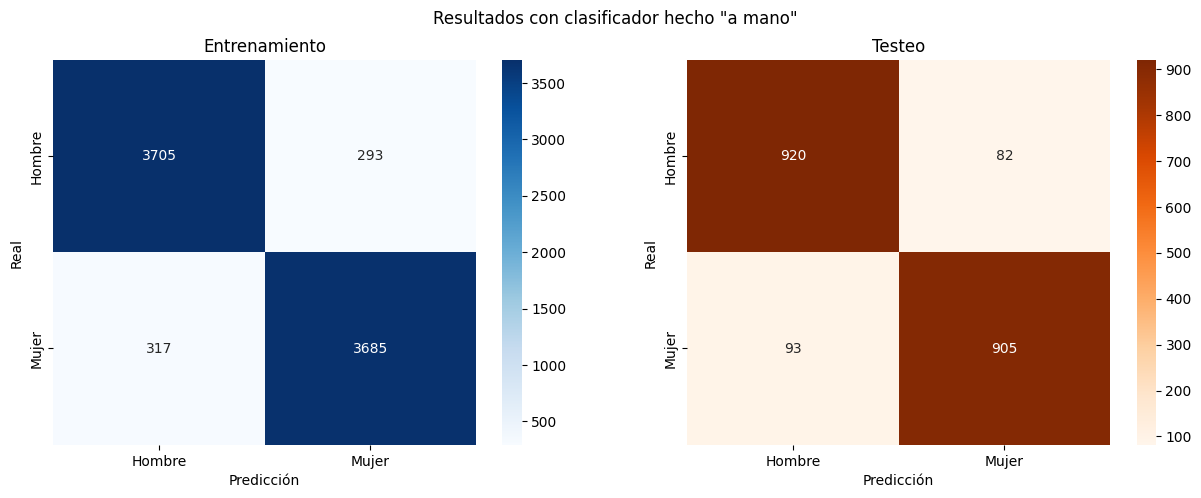

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Resultados con clasificador hecho "a mano"')

sns.heatmap(cm_manual_train, annot=True, fmt="d", cmap="Blues", ax=ax[0],  xticklabels= etiquetas, yticklabels= etiquetas)
ax[0].set_title("Entrenamiento")
ax[0].set_xlabel("Predicción")
ax[0].set_ylabel("Real")

sns.heatmap(cm_manual_test, annot=True, fmt="d", cmap="Oranges", ax=ax[1], xticklabels= etiquetas, yticklabels= etiquetas)
ax[1].set_title("Testeo")
ax[1].set_xlabel("Predicción")
ax[1].set_ylabel("Real")
plt.show()

In [187]:
def clasificador_manual_A_2(wh_vector, genero_vector):
    cant_noClasificados=0
    prediccion=[] #en este vector guardo los resultados de la predicción
    probs = []
    #Recorre todos los elementos del array y los clasifica 
    for i in range(len(genero_vector)):
        #print("Evalúo el elemento ",i, "---PESO=", peso_train[i], "---ALTURA=", altura_train[i])
        proba_wh, likelihood_hombre,clasificado= probabilidad_wh_A(wh_vector[i], 'Hombre')

        if clasificado==True:
            #Calculo, por medio del teorema de Bayes, la probabilidad de que sea hombre
            hombre_dado_wh= (likelihood_hombre * prior_hombre)/proba_wh
            probs.append(hombre_dado_wh)
            if(hombre_dado_wh>0.5):
                prediccion.append(1) #de esta forma, HOMBRE=1 MUJER=0
            else:
                prediccion.append(0)
        if clasificado==False:
            cant_noClasificados+=1
            print("La muestra ", i, "no se pudo clasificar")
    
    print("\n\nHUBO ", cant_noClasificados, " ELEMENTOS QUE NO PUDIERON SER CLASIFICADOS")
    #una vez que termina, convierto la lista con las predicciones en array
    prediccion=np.array(prediccion)

    return prediccion, probs

In [ ]:
p = clasificador_manual_A_2(wh_train, genero_train)


<span style="font-size: 24px;"> B. Clasificador de SciKit-Learn </span>

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
clf_sklearn = GaussianNB()
clf_sklearn.fit(wh_train, genero_train_binario)  # Entrenar el modelo


GaussianNB()

<span style="font-size: 20px;"> B. 1. Imágenes de entrenamiento </span>

In [ ]:
prediccion_sklearn_train = clf_sklearn.predict(wh_train)

<span style="font-size: 20px;"> B. 2. Imágenes de testeo </span>

In [ ]:
prediccion_sklearn_test = clf_sklearn.predict(wh_test)

<span style="font-size: 20px;"> B. 3. Métricas </span>

Calculamos el accuracy con la función de la propia librería Scikit-Learn

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_sklearn_train = accuracy_score(genero_train_binario, prediccion_sklearn_train )
accuracy_sklearn_test = accuracy_score(genero_test_binario, prediccion_sklearn_test)


In [ ]:
print("ACCURACY DEL MODELO ENTRENADO CON SCIKIT-LEARN")
print("\tConjunto de entrenamiento: ", accuracy_sklearn_train, "\n\tConjunto de testeo: ", accuracy_sklearn_test)

ACCURACY DEL MODELO ENTRENADO CON SCIKIT-LEARN
	Conjunto de entrenamiento:  0.887 
	Conjunto de testeo:  0.887


Para dar una mayor idea sobre el desempeño del modelo, mostramos las matrices de confusión.

In [ ]:
cm_sklearn_train=confusion_matrix(genero_train_binario, prediccion_sklearn_train)
cm_sklearn_test=confusion_matrix(genero_test_binario, prediccion_sklearn_test)


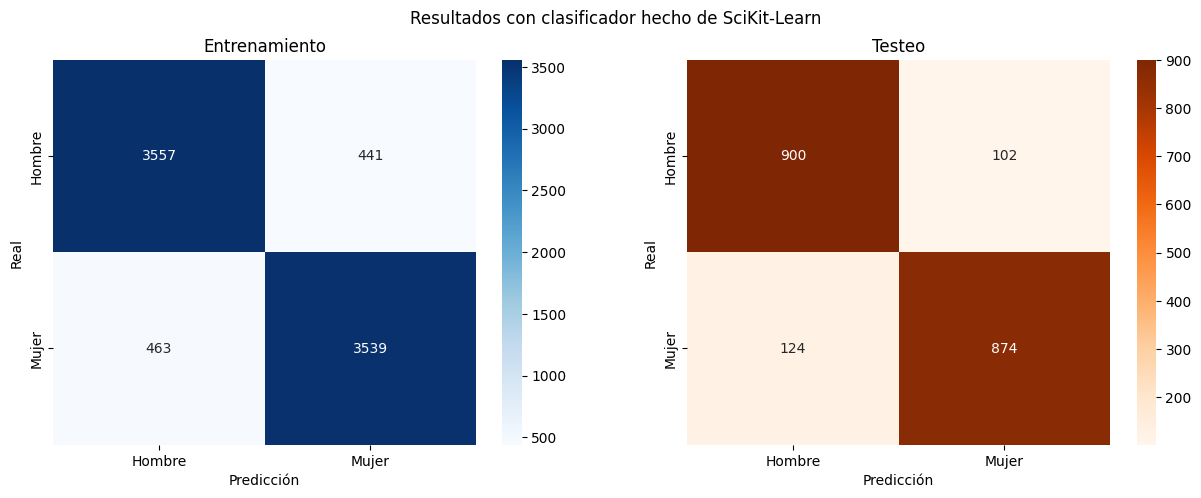

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Resultados con clasificador hecho de SciKit-Learn')

sns.heatmap(cm_sklearn_train, annot=True, fmt="d", cmap="Blues", ax=ax[0],  xticklabels= etiquetas, yticklabels= etiquetas)
ax[0].set_title("Entrenamiento")
ax[0].set_xlabel("Predicción")
ax[0].set_ylabel("Real")

sns.heatmap(cm_sklearn_test, annot=True, fmt="d", cmap="Oranges", ax=ax[1], xticklabels= etiquetas, yticklabels= etiquetas)
ax[1].set_title("Testeo")
ax[1].set_xlabel("Predicción")
ax[1].set_ylabel("Real")
plt.show()

<span style="font-size: 24px;"> C. Clasificación con método de Expansión Cuadrática </span>

In [ ]:
#PREPARO EL VECTOR CON LOS DATOS
def expandir_datos(wh_vector):
    datos_extension=np.zeros([len(wh_vector), 5])
    for i in range(len(wh_vector)):
        peso=wh_train[i, 0]
        altura=wh_train[i, 1]
        datos_extension[i, 0]=peso
        datos_extension[i, 1]=peso**2
        datos_extension[i, 2]=altura
        datos_extension[i, 3]=altura**2
        datos_extension[i, 4]=peso*altura
    return datos_extension

In [ ]:
datos_expansion_train= expandir_datos(wh_train)
datos_expansion_test=expandir_datos(wh_test)

In [ ]:
#Entrenamos el modelo
clf_expansion = GaussianNB()
clf_expansion.fit(datos_expansion_train, genero_train_binario)  

GaussianNB()

<span style="font-size: 20px;"> C. 1. Imágenes de entrenamiento </span>

In [ ]:
prediccion_expansion_train = clf_expansion.predict(datos_expansion_train)

<span style="font-size: 20px;"> C. 2. Imágenes de testeo </span>

In [ ]:
prediccion_expansion_test = clf_expansion.predict(datos_expansion_test)

<span style="font-size: 20px;"> C. 3. Métricas </span>

In [ ]:
accuracy_expansion_train = accuracy_score(genero_train_binario, prediccion_expansion_train )
accuracy_expansion_test = accuracy_score(genero_test_binario, prediccion_expansion_test)
print("ACCURACY DEL MODELO ENTRENADO CON DATOS EXPANDIDOS")
print("\tConjunto de entrenamiento: ", accuracy_expansion_train, "\n\tConjunto de testeo: ", accuracy_expansion_test)


ACCURACY DEL MODELO ENTRENADO CON DATOS EXPANDIDOS
	Conjunto de entrenamiento:  0.890375 
	Conjunto de testeo:  0.495


In [ ]:
cm_expansion_train=confusion_matrix(genero_train_binario, prediccion_expansion_train)
cm_expansion_test=confusion_matrix(genero_test_binario, prediccion_expansion_test)

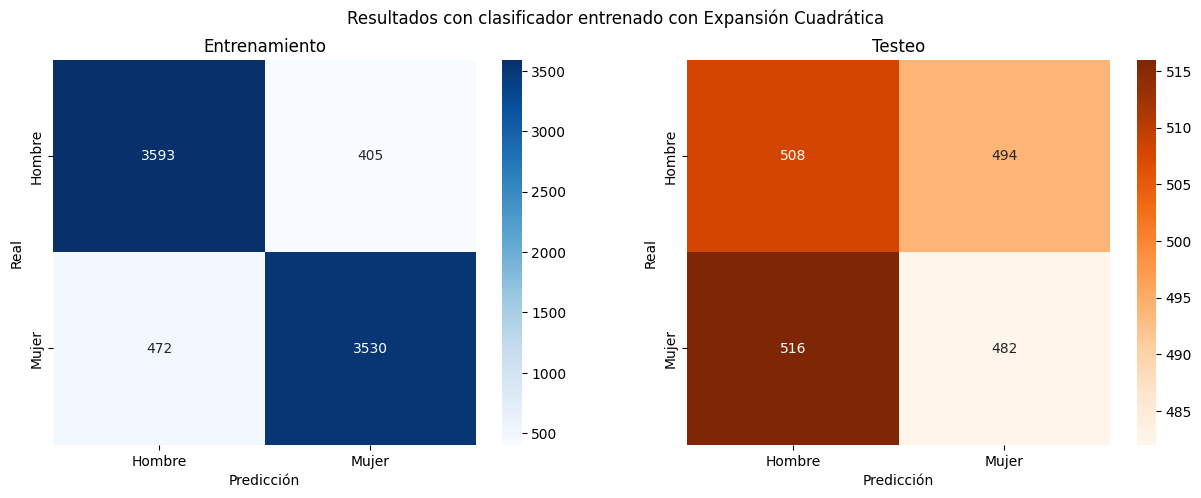

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Resultados con clasificador entrenado con Expansión Cuadrática')
sns.heatmap(cm_expansion_train, annot=True, fmt="d", cmap="Blues", ax=ax[0],  xticklabels= etiquetas, yticklabels= etiquetas)
ax[0].set_title("Entrenamiento")
ax[0].set_xlabel("Predicción")
ax[0].set_ylabel("Real")

sns.heatmap(cm_expansion_test, annot=True, fmt="d", cmap="Oranges", ax=ax[1], xticklabels= etiquetas, yticklabels= etiquetas)
ax[1].set_title("Testeo")
ax[1].set_xlabel("Predicción")
ax[1].set_ylabel("Real")
plt.show()

## Umbrales and shit

In [266]:
x_min, x_max = wh_train[:, 0].min() - 1, wh_train[:, 0].max() + 1
y_min, y_max = wh_train[:, 1].min() - 1, wh_train[:, 1].max() + 1

# Crear la malla
# Tamaño del paso de la malla
xx, yy = np.meshgrid(np.arange(x_min, x_max, ancho_bines_altura),
                     np.arange(y_min, y_max, ancho_bines_peso))

def clasificar_malla_A(xx, yy):
    """Clasifica cada punto de la malla usando el clasificador bayesiano propio."""
    puntos = np.c_[xx.ravel(), yy.ravel()]
    clases = []
    
    for punto in puntos:
        proba_wh, likelihood_hombre, clasificado = probabilidad_wh_A(punto, 'Hombre')
        if clasificado:
            hombre_dado_wh = (likelihood_hombre * prior_hombre) / proba_wh
            clases.append(hombre_dado_wh)
        else:
            # En lugar de 0, asignamos una probabilidad neutra, por ejemplo 0.5
            clases.append(0.5)
    
    return np.array(clases).reshape(xx.shape)

def clasificar_malla_B(xx, yy):
    """Clasifica cada punto de la malla usando el clasificador bayesiano propio."""
    puntos = np.c_[xx.ravel(), yy.ravel()]
    clases = []
    
    for punto in puntos:
        proba_wh, likelihood_hombre = probabilidad_wh_B(punto, 'Hombre', 0)  # Usamos la función propia
        hombre_dado_wh = (likelihood_hombre * prior_hombre) / proba_wh
        clases.append(hombre_dado_wh)
    
    return np.array(clases).reshape(xx.shape)

def clasificar_malla_sklearn(xx, yy):
    """Clasifica cada punto de la malla usando el clasificador bayesiano de sklearn."""
    puntos = np.c_[xx.ravel(), yy.ravel()]
    clases = clf_sklearn.predict(puntos)  # Usamos el clasificador de sklearn
    
    return clases.reshape(xx.shape) 
def clasificar_malla_expansion(xx, yy):
    """Clasifica cada punto de la malla usando el clasificador bayesiano de sklearn."""
    puntos = np.c_[xx.ravel(), xx.ravel()**2, yy.ravel(), yy.ravel()**2, xx.ravel()*yy.ravel()]
    clases = clf_expansion.predict(puntos)  # Usamos el clasificador de sklearn
    
    return clases.reshape(xx.shape)

C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_22172\2302028831.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


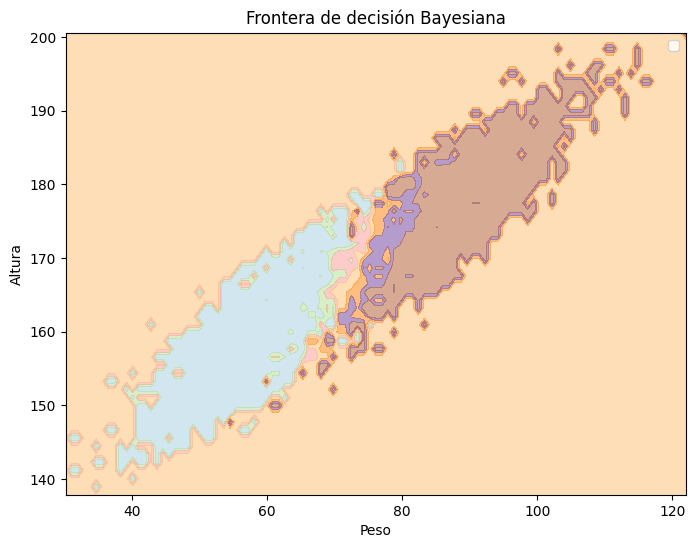

In [263]:

# Obtener las predicciones para la malla
Z_a = clasificar_malla_A(xx, yy)

# Graficar la frontera de decisión
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z_a, alpha=.5, cmap=plt.cm.Paired)
#plt.scatter(data_hombres_train[:, 0], data_hombres_train[:, 1], c='blue', label='Hombres')
#plt.scatter(data_mujeres_train[:, 0], data_mujeres_train[:, 1], c='red', label='Mujeres')
plt.xlabel('Peso')
plt.ylabel('Altura')
plt.legend()
plt.title('Frontera de decisión Bayesiana')
plt.show()


Para la muestra  0 Se amplió  3 veces el espacio de comparación
Para la muestra  0 Se amplió  3 veces el espacio de comparación
Para la muestra  0 Se amplió  3 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  1 veces el espacio de comparación
Para la muestra  0 Se amplió  1 veces el espacio de comparación
Para la muestra  0 Se amplió  1 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  3 veces el

C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_22172\1719077019.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


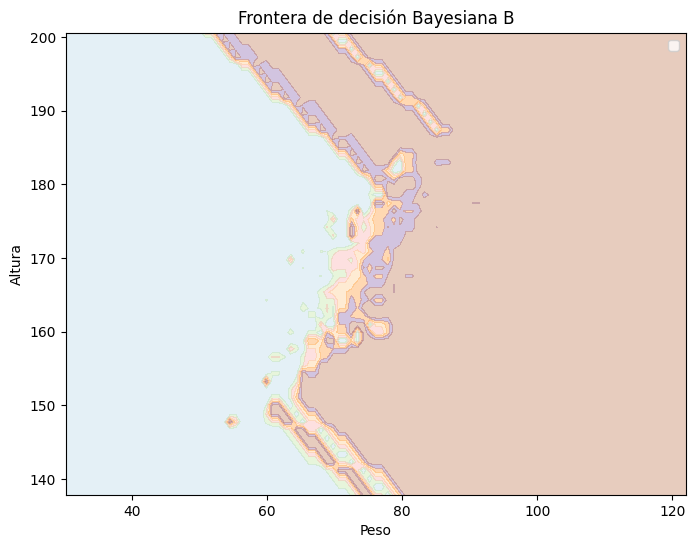

In [253]:
Z_b = clasificar_malla_B(xx, yy)
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z_b, alpha=0.3, cmap=plt.cm.Paired)
plt.xlabel('Peso')
plt.ylabel('Altura')
plt.legend()
plt.title('Frontera de decisión Bayesiana B')
plt.show()


C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_22172\1665448412.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


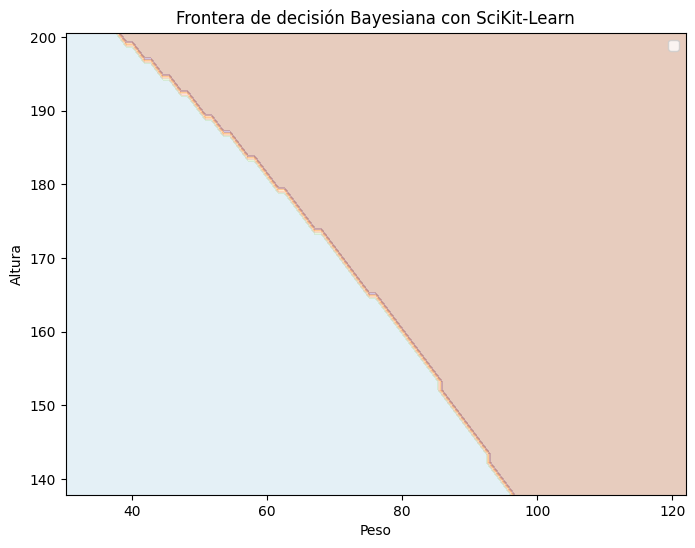

In [219]:
Z_sklearn = clasificar_malla_sklearn(xx, yy)
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z_sklearn, alpha=0.3, cmap=plt.cm.Paired)
plt.xlabel('Peso')
plt.ylabel('Altura')
plt.legend()
plt.title('Frontera de decisión Bayesiana con SciKit-Learn')
plt.show()

C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_22172\71053724.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


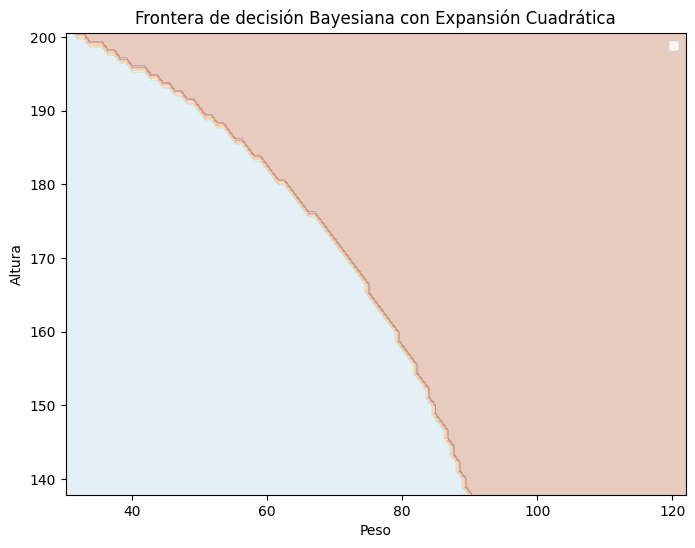

In [268]:
Z_expansion = clasificar_malla_expansion(xx, yy)
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z_expansion, alpha=0.3, cmap=plt.cm.Paired)
plt.xlabel('Peso')
plt.ylabel('Altura')
plt.legend()
plt.title('Frontera de decisión Bayesiana con Expansión Cuadrática')
plt.show()